# Import modules

In [1]:
import torch
import torch.optim as optim
from pathlib import Path
import logging
from omegaconf import OmegaConf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd

import seaborn as sns
from models.config_classes import Config
from models.autoencoder import KoopmanAutoencoder

from models.dataloader import create_dataloaders
from models.metrics import Metric
from models.utils import load_checkpoint, load_datasets

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger(__name__)

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")

cmap = sns.color_palette("icefire", as_cmap=True)

# Configuration


In [2]:
CONFIG_PATH = Path("./configs/model/128_inc.yaml")  # Update this path
# CKPT_PATH = Path("./model_outputs/128_inc_kl_1.0/dummy-5526m8pc/checkpoints/latest_model.pth")
CKPT_PATH = Path("./model_outputs/128_inc_kl_1.0/run-20250615_122521/checkpoints/best_model.pth")
INITIAL_SAMPLE_INDEX = 100
ROLL_OUT_STEPS = 100
FRAME_STRIDE = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
base_config = OmegaConf.structured(Config)
file_config = OmegaConf.load(CONFIG_PATH)

cfg = OmegaConf.merge(base_config, file_config)
OmegaConf.resolve(cfg)
# cfg['training']['use_checkpoint'] = False  # Don't checkpoint during testing

train_dataset, val_dataset, test_dataset = load_datasets(cfg)
train_loader, val_loader, test_loader = create_dataloaders(
            train_dataset, val_dataset, test_dataset, cfg.training
        )

2025-06-15 17:02:48,872 [INFO] Obstacle mask found and processed from static variables.
2025-06-15 17:02:49,927 [INFO] Fitted MeanStdNormalizer.
2025-06-15 17:02:57,313 [INFO] Obstacle mask found and processed from static variables.
2025-06-15 17:02:57,611 [INFO] Fitted MeanStdNormalizer.
2025-06-15 17:02:58,589 [INFO] Obstacle mask found and processed from static variables.
2025-06-15 17:02:58,623 [INFO] Fitted MeanStdNormalizer.
2025-06-15 17:02:58,686 [INFO] Successfully loaded datasets with type 'QGDatasetMultiSim'.


#  Load Model 


In [4]:
model = KoopmanAutoencoder(
            data_variables=cfg.data.variables,
            input_frames=cfg.data.input_sequence_length,
            height=cfg.model.height,
            width=cfg.model.width,
            latent_dim=cfg.model.latent_dim,
            hidden_dims=cfg.model.hidden_dims,
            transformer_config=cfg.model.transformer,
            use_checkpoint=cfg.training.use_checkpoint,
            predict_re=cfg.model.predict_re,
            re_grad_enabled=cfg.model.re_grad_enabled,
            **cfg.model.conv_kwargs,
        ).to(DEVICE)
model_params = model.parameters()
optimizer = optim.Adam(model_params, lr=cfg.lr_scheduler.lr)
if CKPT_PATH is not None:
    print(f"Loading from checkpoint: {CKPT_PATH}")
    model, _, _, _ = load_checkpoint(CKPT_PATH, model=model, optimizer=optimizer)

model.eval()

Loading from checkpoint: model_outputs/128_inc_kl_1.0/run-20250615_122521/checkpoints/best_model.pth


2025-06-15 17:02:59,775 [INFO] Checkpoint loaded from model_outputs/128_inc_kl_1.0/run-20250615_122521/checkpoints/best_model.pth. Resuming from epoch 21.


KoopmanAutoencoder(
  (history_encoder): HistoryEncoder(
    (linear): Linear(in_features=8192, out_features=1024, bias=True)
    (layers): Sequential(
      (0): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ConvBlock(
        (stack): ModuleList(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (1): ReLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
          (3): ReLU()
        )
      )
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): ConvBlock(
        (s

#  Run Rollout


In [5]:
def run_long_rollout(model, input_seq, rollout_steps):
    input_seq = input_seq.unsqueeze(0).to(DEVICE)  # [1, T, C, H, W]

    with torch.no_grad():
        out = model(input_seq, seq_length=rollout_steps)

    return out  # [T+rollout_steps, C, H, W]

#  Visualize


In [6]:
input_seq, ground_truth, metadata = test_dataset[INITIAL_SAMPLE_INDEX, ROLL_OUT_STEPS]
input_seq["obstacle_mask"] = metadata["obstacle_mask"][0].repeat(*input_seq.batch_size, 1, 1)
print(input_seq)
total_predicted_seq = run_long_rollout(model, input_seq, ROLL_OUT_STEPS)
predicted_seq = total_predicted_seq.x_preds.cpu()
print(total_predicted_seq)

/home/rg625/anaconda3/envs/samudra/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TensorDict(
    fields={
        obstacle_mask: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        p: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([2, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([2]),
    device=None,
    is_shared=False)
KoopmanOutput(x_recon=TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_x: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True),
        v_y: Tensor(shape=torch.Size([1, 64, 128]), device=cuda:0, dtype=torch.float32, is_shared=True)},
    batch_size=torch.Size([1]),
    device=None,
    is_shared=False), x_preds=TensorDict(
    fields={
        p: Tensor(s

#  Plot Results 


In [7]:
	
def compute_vorticity(vx, vy):
    vxDx, vxDy = torch.gradient(vx, dim=(1, 2))  # vx: [T, H, W]
    vyDx, vyDy = torch.gradient(vy, dim=(1, 2))
    return vyDx - vxDy  # [T, H, W]

def plot_rollout(gt_dict, pred_dict, variable_name, frame_stride=5):
    """
    Plots the rollout comparison between ground truth and predicted sequence for a given variable.

    Args:
        gt_dict (TensorDict): TensorDict of ground truth tensors [T, H, W] per variable.
        pred_dict (TensorDict): TensorDict of predicted tensors [T, H, W] per variable.
        variable_name (str): The key for the variable to visualize.
        frame_stride (int): Step between frames to plot.
    """
    # Remove batch dimension if present
    if gt_dict.batch_dims == 1 and gt_dict.batch_size[0] == 1:
        gt_dict = gt_dict.squeeze(0)
    if pred_dict.batch_dims == 1 and pred_dict.batch_size[0] == 1:
        pred_dict = pred_dict.squeeze(0)

    gt = gt_dict[variable_name]  # shape: [T, H, W]
    pred = pred_dict[variable_name]  # shape: [T, H, W]

    print(f"Max {variable_name} (GT): {gt.max()}")
    print(f"Max {variable_name} (Pred): {pred.max()}" )
    print(f"Min {variable_name} (GT): {gt.min()}" )
    print(f"Min {variable_name} (Pred): {pred.min()}" )
    print(f"Mean {variable_name} (GT): {gt.mean()}" )
    print(f"Mean {variable_name} (Pred): {pred.mean()}" )
    print(f"Std {variable_name} (GT): {gt.std()}" )
    print(f"std {variable_name} (Pred): {pred.std()}" )

    num_frames = min(gt.shape[0], pred.shape[0])
    indices = list(range(0, num_frames, frame_stride))
    num_plots = min(len(indices), 15)

    fig = plt.figure(figsize=(1.8 * num_plots, 6))
    spec = gridspec.GridSpec(3, num_plots + 1, width_ratios=[1] * num_plots + [0.05])

    for i, idx in enumerate(indices[:num_plots]):
        # Ground truth
        ax_gt = fig.add_subplot(spec[0, i])
        im_gt = ax_gt.imshow(gt[idx].cpu(), cmap=cmap)
        ax_gt.set_title(f"t={idx}")
        ax_gt.axis('off')
        plt.colorbar(im_gt, ax=ax_gt, fraction=0.046, pad=0.04)
        # Prediction
        ax_pred = fig.add_subplot(spec[1, i])
        im_pred = ax_pred.imshow(pred[idx].cpu(), cmap=cmap)
        ax_pred.axis('off')
        plt.colorbar(im_pred, ax=ax_pred, fraction=0.046, pad=0.04)

        err = gt[idx] - pred[idx]
        ax_err = fig.add_subplot(spec[2, i])
        im_err = ax_err.imshow(err.cpu(), cmap=cmap)
        ax_err.axis('off')
        plt.colorbar(im_err, ax=ax_err, fraction=0.046, pad=0.04)
    # Add shared colorbar
    # cbar_ax = fig.add_subplot(spec[:, -1])
    # fig.colorbar(im_pred, cax=cbar_ax)

    fig.suptitle(f"Koopman AE Rollout for Variable: {variable_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0.4, 0.98, 0.95])
    plt.show()

true Re: (tensor(500.), 'target')
pred Re: tensor([0.7626, 0.5494, 0.7122, 0.7417, 0.6464, 0.6031, 0.5317, 0.6368, 0.6686,
        0.6500, 0.6644, 0.6216, 0.5666, 0.6034, 0.6136, 0.6183, 0.6705, 0.6569,
        0.6079, 0.5915, 0.5878, 0.5957, 0.6275, 0.6355, 0.6186, 0.6001, 0.5832,
        0.5798, 0.5959, 0.6146, 0.6235, 0.6180, 0.6035, 0.5948, 0.5982, 0.6090,
        0.6216, 0.6284, 0.6269, 0.6229, 0.6224, 0.6280, 0.6388, 0.6491, 0.6534,
        0.6516, 0.6476, 0.6453, 0.6459, 0.6485, 0.6505, 0.6501, 0.6470, 0.6427,
        0.6394, 0.6381, 0.6381, 0.6379, 0.6361, 0.6332, 0.6307, 0.6305, 0.6332,
        0.6388, 0.6461, 0.6539, 0.6618, 0.6701, 0.6794, 0.6900, 0.7013, 0.7126,
        0.7235, 0.7342, 0.7452, 0.7569, 0.7692, 0.7816, 0.7933, 0.8038, 0.8131,
        0.8212, 0.8281, 0.8331, 0.8348, 0.8314, 0.8210, 0.8025, 0.7758, 0.7416,
        0.7003, 0.6519, 0.5960, 0.5331, 0.4651, 0.3955, 0.3281, 0.2664, 0.2128,
        0.1681])
average Re: 0.6422210931777954


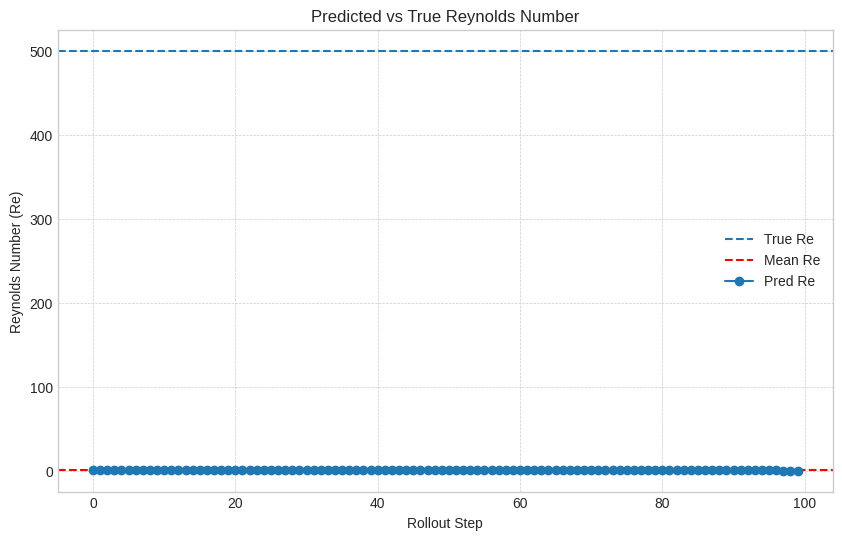

TensorDict(
    fields={
        p: Tensor(shape=torch.Size([100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([100]),
    device=None,
    is_shared=False)
TensorDict(
    fields={
        p: Tensor(shape=torch.Size([1, 100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_x: Tensor(shape=torch.Size([1, 100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
        v_y: Tensor(shape=torch.Size([1, 100, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False)},
    batch_size=torch.Size([1, 100]),
    device=cpu,
    is_shared=False)
Max p (GT): 2.603456497192383
Max p (Pred): 17.510847091674805
Min p (GT): -3.6233458518981934
Min p (Pred): -27.067424774169922
Mean p (GT): -0.23357410728931427
Mean

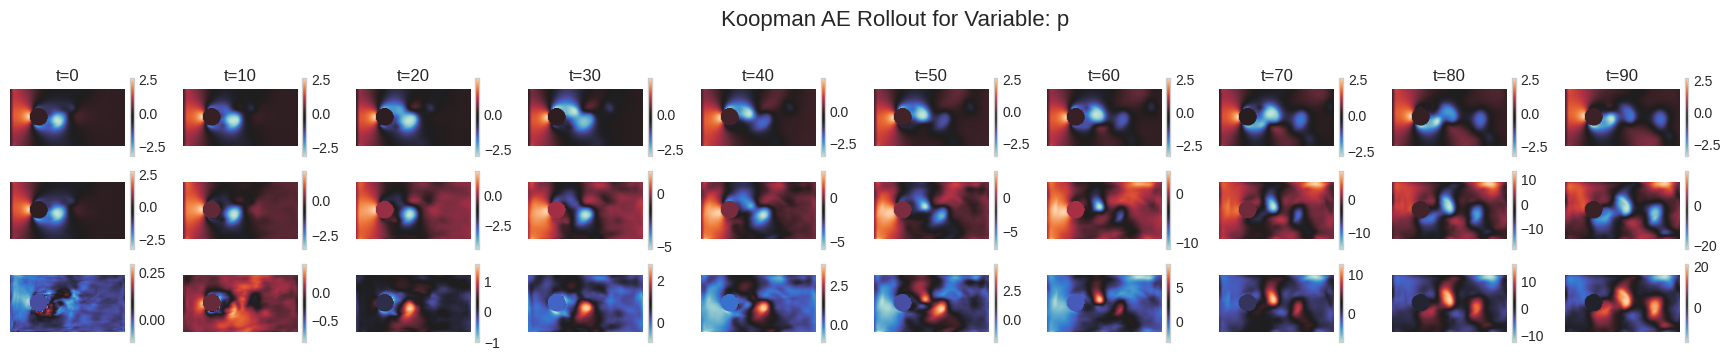

Max v_x (GT): 2.4486780166625977
Max v_x (Pred): 24.522377014160156
Min v_x (GT): -4.066826343536377
Min v_x (Pred): -27.027690887451172
Mean v_x (GT): 0.11758226156234741
Mean v_x (Pred): 0.0633278638124466
Std v_x (GT): 0.9895820021629333
std v_x (Pred): 4.170063495635986


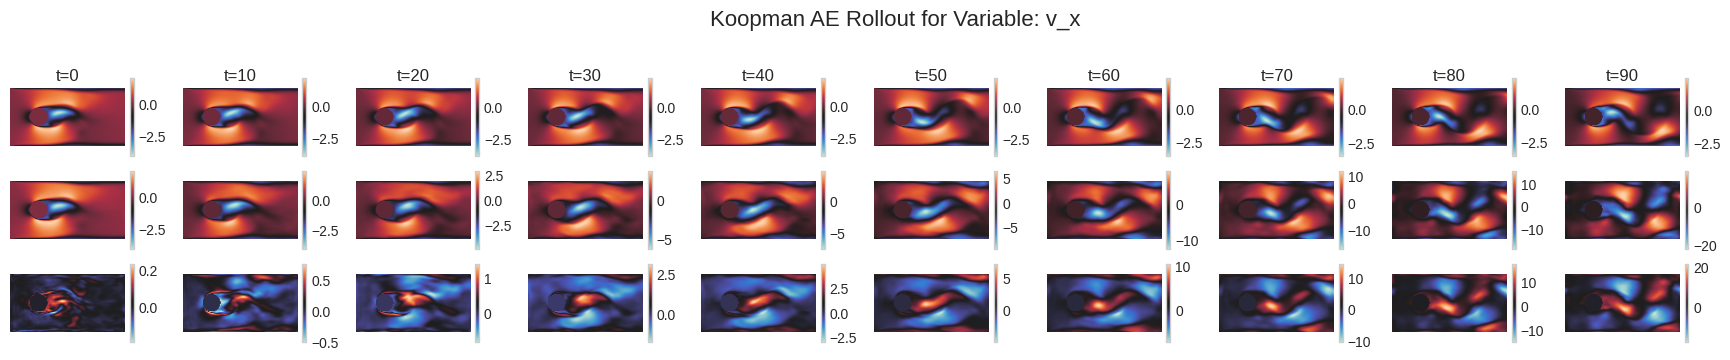

Max v_y (GT): 3.478713035583496
Max v_y (Pred): 42.275272369384766
Min v_y (GT): -3.662752628326416
Min v_y (Pred): -33.86693572998047
Mean v_y (GT): -0.03663238137960434
Mean v_y (Pred): -0.14290469884872437
Std v_y (GT): 0.8562988638877869
std v_y (Pred): 4.834395885467529


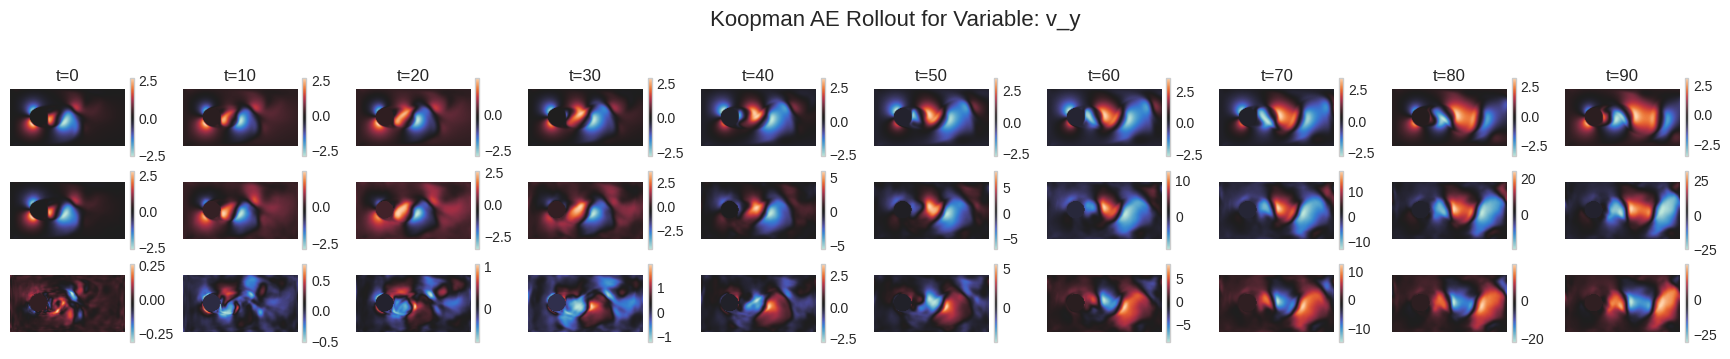

Max vort (GT): 2.4120850563049316
Max vort (Pred): 9.404266357421875
Min vort (GT): -0.8801743984222412
Min vort (Pred): -6.356119155883789
Mean vort (GT): 0.0001860569027485326
Mean vort (Pred): -0.0014311885461211205
Std vort (GT): 0.1854456216096878
std vort (Pred): 0.7817209959030151


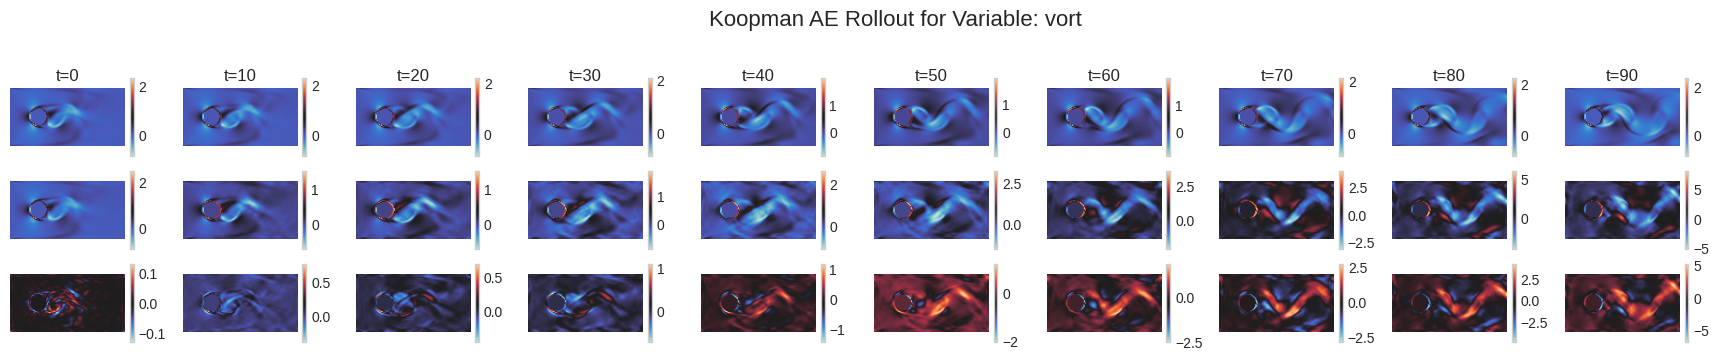

In [8]:
print(f'true Re: {metadata["Re"]}')
print(f'pred Re: {total_predicted_seq.reynolds.squeeze().cpu()}')
mean_re = total_predicted_seq.reynolds.squeeze().cpu().mean()
print(f'average Re: {mean_re}')

# Create the plot
plt.figure(figsize=(10, 6))
plt.axhline(metadata["Re"][0].item(), linestyle='--', label='True Re')
plt.axhline(mean_re, linestyle='--', color='r', label='Mean Re')
plt.plot(total_predicted_seq.reynolds.squeeze().cpu(), label='Pred Re', marker='o', linestyle='-')

# --- Add axis labels ---
plt.xlabel("Rollout Step")
plt.ylabel("Reynolds Number (Re)")
# ---

plt.title("Predicted vs True Reynolds Number")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

print(ground_truth)
print(predicted_seq)
plot_rollout(ground_truth.cpu(), predicted_seq.squeeze().cpu(), variable_name="p", frame_stride=FRAME_STRIDE)
plot_rollout(ground_truth.cpu(), predicted_seq.squeeze().cpu(), variable_name="v_x", frame_stride=FRAME_STRIDE)
plot_rollout(ground_truth.cpu(), predicted_seq.squeeze().cpu(), variable_name="v_y", frame_stride=FRAME_STRIDE)

# Compute vorticity from vx and vy
vort_gt = compute_vorticity(ground_truth["v_x"], ground_truth["v_y"])
vort_pred = compute_vorticity(predicted_seq["v_x"].squeeze(), predicted_seq["v_y"].squeeze())

# Add derived vorticity to the TensorDicts
ground_truth["vort"] = vort_gt
predicted_seq["vort"] = vort_pred.unsqueeze(0)

# Plot vorticity
plot_rollout(ground_truth.squeeze().cpu(), predicted_seq.squeeze().cpu(), variable_name="vort", frame_stride=FRAME_STRIDE)


Long Rollout SSIM Metric: 0.4338


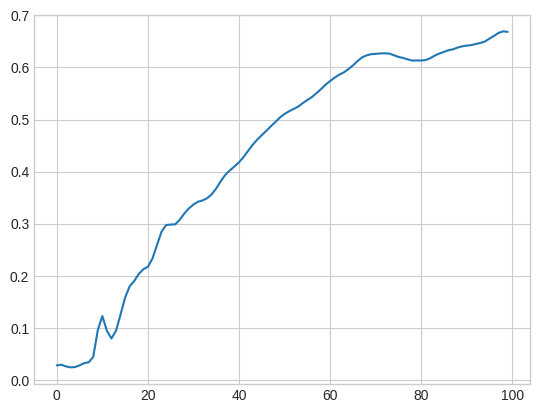

In [9]:
metric = Metric(
    mode=cfg.metric.mode,
    variable_mode="single",
    variable_name="vort"
)
target_denorm = test_loader.denormalize(ground_truth.unsqueeze(0))
preds_denorm = test_loader.denormalize(predicted_seq)

metric_val = metric(
    test_loader.to_unit_range(target_denorm),
    test_loader.to_unit_range(preds_denorm),
)
print(f"\nLong Rollout {cfg.metric.mode} Metric: {metric_val.mean().item():.4f}")
plt.plot(metric_val.squeeze().cpu().detach().numpy())
plt.show()

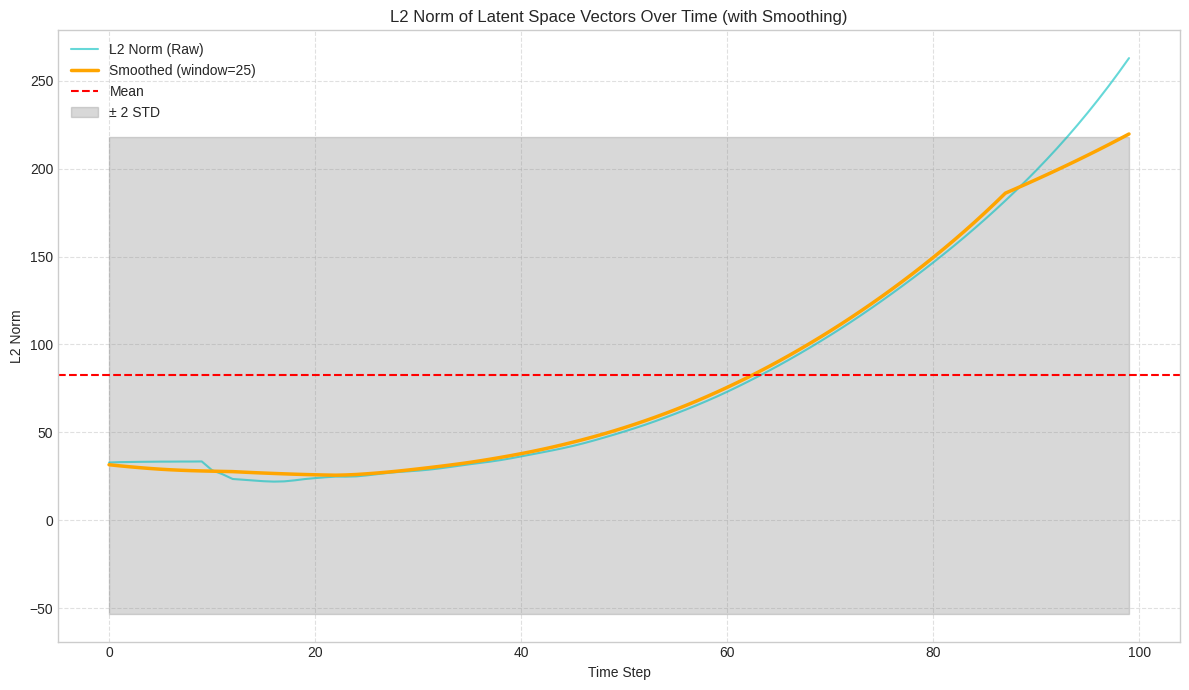

In [10]:

z_preds = total_predicted_seq.z_preds.cpu().detach()

if z_preds.ndim > 2:
    z_preds = z_preds.squeeze()

z_preds_cpu = z_preds.cpu().detach()
latent_norms = torch.norm(z_preds_cpu, dim=-1)
latent_mean = latent_norms.mean()
latent_std = latent_norms.std()

window_size = 25
latent_norms_series = pd.Series(latent_norms.numpy())

smoothed_norms = latent_norms_series.rolling(
    window=window_size,
    center=True,
    min_periods=1
).mean()

fig, ax = plt.subplots(figsize=(12, 7))

time_steps = range(len(latent_norms))
ax.plot(
    time_steps,
    latent_norms.numpy(),
    label='L2 Norm (Raw)',
    color='c',
    linewidth=1.5,
    alpha=0.6
)

ax.plot(
    time_steps,
    smoothed_norms,
    label=f'Smoothed (window={window_size})',
    color='orange',
    linewidth=2.5
)

ax.axhline(latent_mean.item(), color='r', linestyle='--', label='Mean')
upper_bound = latent_mean + 2 * latent_std
lower_bound = latent_mean - 2 * latent_std
ax.fill_between(
    time_steps,
    lower_bound.item(),
    upper_bound.item(),
    color='gray',
    alpha=0.3,
    label='± 2 STD'
)

ax.set_title("L2 Norm of Latent Space Vectors Over Time (with Smoothing)")
ax.set_xlabel("Time Step")
ax.set_ylabel("L2 Norm")
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend() # Add a legend to identify all lines

plt.tight_layout()
plt.show()

In [11]:
K_residual_matrix = model.koopman_operator.koopman_linear.weight.T.detach().cpu().numpy()

# logger.info(f"Matrix shape: {K_residual_matrix.shape}")

# # Visualize the matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(K_residual_matrix, cmap="icefire", center=0)
# plt.title("Heatmap of the Learned Residual Koopman Operator (K_res)", fontsize=16)
# plt.xlabel("Latent Dimension", fontsize=12)
# plt.ylabel("Latent Dimension", fontsize=12)
# plt.show()

2025-06-15 17:03:14,804 [INFO] Computed 1024 eigenvalues.


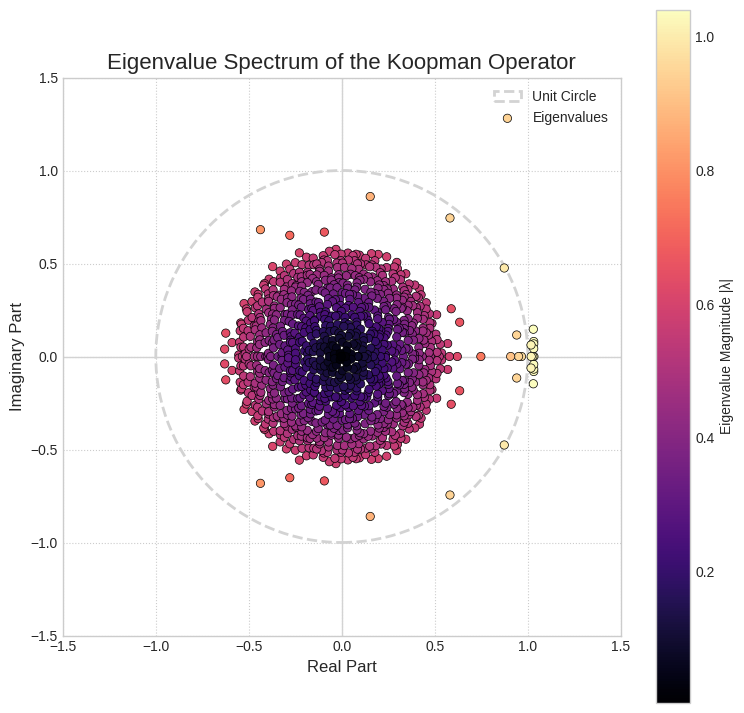

In [12]:
# Create the full Koopman matrix K = I + K_res
latent_dim = model.latent_dim
identity_matrix = np.identity(latent_dim)
K_full_matrix = K_residual_matrix # +identity_matrix 

# Compute the eigenvalues
eigenvalues = np.linalg.eigvals(K_full_matrix)

logger.info(f"Computed {len(eigenvalues)} eigenvalues.")

# --- Visualize the Eigenvalue Spectrum ---
plt.figure(figsize=(9, 9))
ax = plt.gca()

# Plot the unit circle for reference (the stability boundary)
unit_circle = plt.Circle((0, 0), 1, color='lightgray', fill=False, linestyle='--', linewidth=2, label='Unit Circle')
ax.add_patch(unit_circle)

# Plot the eigenvalues
plt.scatter(
    eigenvalues.real,
    eigenvalues.imag,
    c=np.abs(eigenvalues),
    cmap="magma",
    marker="o",
    edgecolor="k",
    linewidth=0.5,
    zorder=3, # Plot eigenvalues on top of the circle
    label="Eigenvalues"
)

# Formatting
ax.axvline(0, color='lightgray', linestyle='-', lw=1)
ax.axhline(0, color='lightgray', linestyle='-', lw=1)
ax.set_aspect('equal', adjustable='box')
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
plt.title("Eigenvalue Spectrum of the Koopman Operator", fontsize=16)
plt.xlabel("Real Part", fontsize=12)
plt.ylabel("Imaginary Part", fontsize=12)
plt.legend()
plt.colorbar(label="Eigenvalue Magnitude |λ|")
plt.grid(True, linestyle=':')
plt.show()